In [1]:
import time
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter

In [28]:
class simulator:
    def __init__(self, vinit) -> None:
        self.v_prev = vinit

    def voltage_calculator(self,vd,vc):
        v_ch = vc
        v_next = self.v_prev + (v_ch - vd)
        
        if(v_next>=4.4):
            v_next=4.4
        elif(v_next<=3.2):
            v_next=3.2
        self.v_prev = v_next
        return v_next
    


class ControlSystem:
    def __init__(self, Kp=0.7,Ki=0.001,Kd=0.3,Vdesired=4) -> None:
        self.Kp=Kp
        self.Ki=Ki
        self.Kd=Kd
        self.v_desired = Vdesired
        self.last_time = time.time()
        self.sample_time = 1
        self.windup_guard = 10.0
        self.last_error=0
        self.PTerm=0
        self.ITerm=0
        self.DTerm=0
        self.Vdleast=0.12
        self.Vdhigh=1.2
        self.V_c=[0.717233946986578, 0.6834730166406882, 0.7123148732382577, 0.6725737179452767, 0.723087824661398, 0.6911326945309741, 0.7247514073615057, 0.718227730268895, 0.7031694081899404, 0.6988827310952462, 0.6983573091227725, 0.7087485554348443, 0.7319244124375102, 0.6858603652630002, 0.6787982106793541, 0.6785575656027366, 0.6807890986395335, 0.7204267022833434, 0.6908348905626038, 0.721771182569227, 0.6773139585349943, 0.6950094133847272, 0.719862109490652, 0.6982184656038151, 0.7041764427179062]

    def calcerror(self,v_curr):
        error = (self.v_desired-v_curr)
        self.current_time =  time.time()
        delta_time = self.current_time - self.last_time
        delta_error = error - self.last_error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time
        
        self.last_time = self.current_time
        self.last_error = error
        return (self.PTerm + (self.Ki*self.ITerm) + (self.Kd*self.DTerm))

    def get_charging_voltage_pwm(self, time):
        if((time>5 and time<10) or (time>15 and time<20) or (time>25 and time<30) or (time>35 and time<40)):
            return 0
        else:
            vc=0.7
            return vc

    def get_charging_voltage_wholeday(self, time):
        if((time>7 and time<18)):
            return 0.7
        else:
            return self.Vdleast

    def get_charging_voltage(self, time):
        # c=0.7
        # rand = random.randint(1,10)
        # r = random.random()
        # if((int(rand)%2)==0):
        #     vc=c + (r*0.05*c)
        # else:
        #     vc=c - (r*0.05*c)
        return self.V_c[time]
    
    def get_charging_voltage_zero(self, time):
        return 1.2
            

    def calcv_d(self,error,i):
        vc = self.get_charging_voltage_wholeday(i)
        
        vd = vc - error
        # Clamping
        if(vd<=self.Vdleast):
            vd=self.Vdleast
        elif(vd>=self.Vdhigh):
            vd=self.Vdhigh
        # vd=0.264
        return vd,vc


    def calculate_vd(self,v_curr,i):
        error = self.calcerror(v_curr)
        vd,vc = self.calcv_d(error,i)
        return (vd, vc)


def calculate_period(voltage=0.12):
    Estorage=540 #mWm
    Vdd=3
    Ia = 3
    Is = 0.0017
    Cperiod = 60
    T=[10,30,50]
    C=[1,2,3]
    Tnom=13.2  
    
    U=[]
    Vrange=1.2

    Et = Estorage*(voltage/Vrange)
    Ta = (((Et/Vdd)-0.102)/2.9983)
    alpha = Ta/Tnom
    
    for i in range(0,len(T)):
        T[i] = T[i]/alpha
        U.append(C[i]/T[i])

    print(U)
    Uoverall=Ta/Cperiod

    # print("Alpha: {}\t T1: {}\t T2: {}\t Ta={}\t Tb={}".format(alpha,T1,T2,Ta,60-Ta))
    return alpha,Ta,Uoverall, U, T



In [29]:
vcurr = 4.4
sim = simulator(vcurr)
cs = ControlSystem()
time.sleep(2)
print("Starting PID controller with Vinit = {}, Kp = {}, range of Vd:[0.1,0.3]\n".format(vcurr,cs.Kp))

print("Time\t Vd\t VNext\t VCharging")
i=0
voltages=[]
charging_voltages=[]
discharge_voltages=[]
times=[]
Tactive=[]
U=[]
U1=[]
U2=[]
U3=[]
T1=[]
T2=[]
T3=[]
while(True):
    if(i>24):
        break
    voltages.append(vcurr)
    vd,vc = cs.calculate_vd(vcurr,i)
    vcurr = sim.voltage_calculator(vd,vc)
    print("{}\t{}\t{}\t{}".format(i,vd,vcurr,vc))
    time.sleep(1)
    charging_voltages.append(vc)
    discharge_voltages.append(vd)
    times.append(i)
    (alpha,Ta,u, uall, tall) = calculate_period(vd)
    Tactive.append(Ta)
    T1.append(tall[0])
    T2.append(tall[1])
    T3.append(tall[2])
    U.append(u)
    U1.append(uall[0])
    U2.append(uall[1])
    U3.append(uall[2])
    i+=1

    

Starting PID controller with Vinit = 4.4, Kp = 0.7, range of Vd:[0.1,0.3]

Time	 Vd	 VNext	 VCharging
0	0.4607135575699943	4.059286442430006	0.12
[0.1743539360069169, 0.11623595733794462, 0.10461236160415015]
1	0.12	4.059286442430006	0.12
[0.04522259583460931, 0.030148397223072877, 0.027133557500765588]
2	0.16242039133441843	4.016866051095588	0.12
[0.06130003643519906, 0.04086669095679937, 0.036780021861119436]
3	0.12003434796784504	4.0168317031277425	0.12
[0.0452356138053401, 0.030157075870226733, 0.027141368283204056]
4	0.13272552918649316	4.004106173941249	0.12
[0.050045605080186795, 0.03336373672012453, 0.030027363048112075]
5	0.12001900539758233	4.004087168543667	0.12
[0.04522979893059943, 0.03015319928706629, 0.02713787935835966]
6	0.12381715365027414	4.000270014893393	0.12
[0.046669307171895186, 0.031112871447930124, 0.028001584303137112]
7	0.12000754345795736	4.000262471435436	0.12
[0.04522545482514235, 0.030150303216761563, 0.027135272895085407]
8	0.7011438331028048	3.99911863

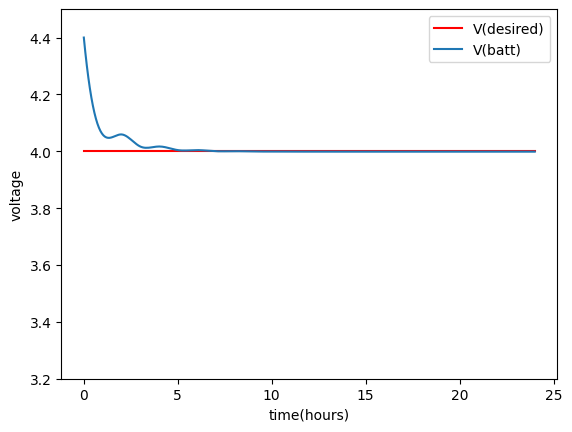

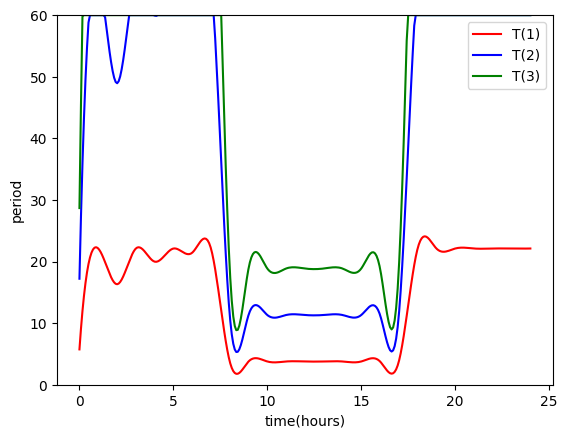

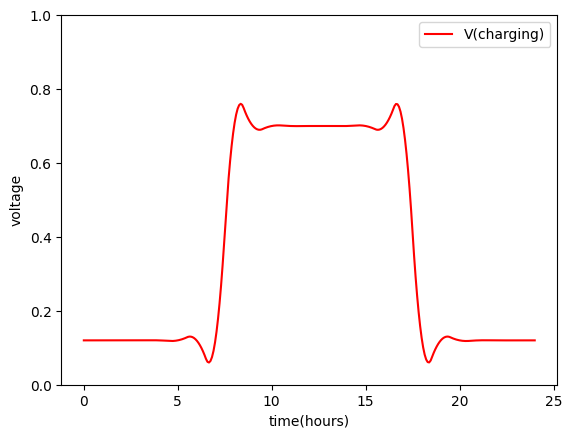

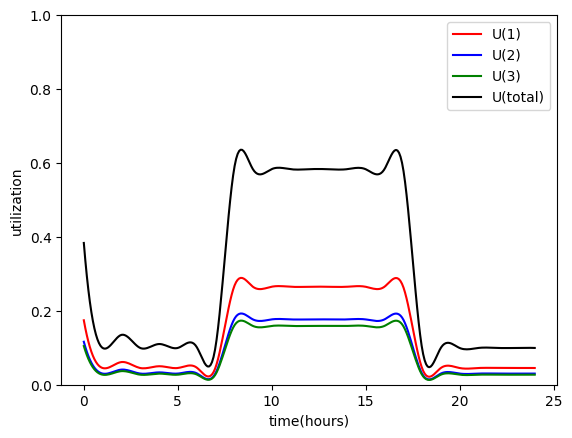

In [30]:
def prun_utilization(u):
    for i in range(0,len(u)):
        if(u[i])<0.01:
            u[i]=0.01

def prun_tactive(t):
    for i in range(0,len(t)):
        if(t[i]>60):
            t[i]=60
        if(t[i]<0):
            t[i]=0
desired_voltages = [cs.v_desired]*len(times)

dir='3.2'
fig, ax = plt.subplots()
t = np.linspace(0,24,300)
spl1 = make_interp_spline(np.array(times), np.array(voltages),k=3 )
voltage_smt = spl1(t)
plt.plot(times,desired_voltages,'red', label='V(desired)')
plt.plot(t,voltage_smt, label='V(batt)')
plt.ylim(3.2,4.5)
plt.xlabel('time(hours)')
plt.ylabel('voltage')
# plt.title('Response of Battery Voltage (Vbatt)')
plt.legend()
# plt.show()
fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/'+dir+'/Vdd.svg')

fig, ax = plt.subplots()
T2=np.array(T2)
spl2 = make_interp_spline(np.array(times),np.array(T1), k=3)
spl3 = make_interp_spline(np.array(times),T2, k=3)
spl8 = make_interp_spline(np.array(times),T3, k=3)
spl7 = make_interp_spline(np.array(times),Tactive, k=3)
T1_smt = spl2(t)
T2_smt = spl3(t)
T3_smt = spl8(t)
prun_tactive(T1_smt)
prun_tactive(T2_smt)
prun_tactive(T3_smt)
Tactive_smt = spl7(t)
plt.plot(t,T1_smt,'red', label='T(1)')
plt.plot(t,T2_smt,'blue', label='T(2)')
plt.plot(t,T3_smt,'green', label='T(3)')
# plt.plot(t,Tactive_smt,'black', label='System Active Period')
# plt.title('Task Period Response')
plt.xlabel('time(hours)')
plt.ylabel('period')
plt.ylim(0,60)
plt.legend()
# plt.show()
fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/'+dir+'/period.svg')

fig, ax = plt.subplots()
spl4 = make_interp_spline(np.array(times), np.array(charging_voltages),k=2)
spl5 = make_interp_spline(np.array(times), np.array(discharge_voltages),k=2)
ch_smt = spl4(t)
dis_smt = spl5(t)
plt.plot(t,ch_smt,'red', label='V(charging)')
# plt.plot(t,dis_smt)
plt.ylim(0,1)
# plt.title('Vcharging at 0.5 with random 5% percent error')
plt.xlabel('time(hours)')
plt.ylabel('voltage')
plt.legend()
# plt.show()
fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/'+dir+'/Vc.svg')

fig, ax = plt.subplots()
spl6 = make_interp_spline(np.array(times), np.array(U1),k=3)
spl9 = make_interp_spline(np.array(times), np.array(U2),k=3)
spl10 = make_interp_spline(np.array(times), np.array(U3),k=3)
spl11 = make_interp_spline(np.array(times), np.array(U),k=3)
U1smt = spl6(t)
U2smt = spl9(t)
U3smt = spl10(t)
Usmt = spl11(t)
prun_utilization(U1smt)
prun_utilization(U2smt)
prun_utilization(U3smt)
prun_utilization(Usmt)
plt.plot(t,U1smt,'red', label='U(1)')
plt.plot(t,U2smt,'blue', label='U(2)')
plt.plot(t,U3smt,'green', label='U(3)')
plt.plot(t,Usmt,'black', label='U(total)')
# plt.title('Utilization of the system in 1 Control Period')
plt.xlabel('time(hours)')
plt.ylabel('utilization')
plt.ylim(0,1)
plt.legend()
plt.show()
fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/'+dir+'/U.svg')

In [163]:
import math
task1=0
task2=0
task3=0
for i in range(0,len(T1)):
    task1+=math.ceil(60/T1[i])
    task2+=math.ceil(60/T2[i])
    task3+=math.ceil(60/T3[i])
print(task1,task2,task3)


print(charging_voltages)

420 152 99
[0.717233946986578, 0.6834730166406882, 0.7123148732382577, 0.6725737179452767, 0.723087824661398, 0.6911326945309741, 0.7247514073615057, 0.718227730268895, 0.7031694081899404, 0.6988827310952462, 0.6983573091227725, 0.7087485554348443, 0.7319244124375102, 0.6858603652630002, 0.6787982106793541, 0.6785575656027366, 0.6807890986395335, 0.7204267022833434, 0.6908348905626038, 0.721771182569227, 0.6773139585349943, 0.6950094133847272, 0.719862109490652, 0.6982184656038151, 0.7041764427179062]


In [11]:
print(Tactive,T1,T2,T3)
print(U)
print(U1)
print(U2)
print(U3)

print('Average utilization:',sum(U)/len(U))

[5.969382650168429, 35.91997858044048, 26.638135869167943, 34.13488823257297, 33.45234810252229, 34.69668654168287, 35.417673164296694, 35.94361561628321, 34.90260341620233, 34.94374714241105, 34.831189947957164, 35.4277548446769, 36.56136377844453, 34.27986447878103, 33.91881036382297, 33.913674055057854, 34.022995625079304, 36.00806839053934, 34.52694461666344, 36.07525627088522, 33.850926472630114, 34.736386822276415, 35.97966357294302, 34.89692326087734, 35.19497185646676] [22.11283942339926, 3.6748351534897075, 4.955301701602256, 3.8670113433692146, 3.9459113481497954, 3.80439785918525, 3.7269529081618082, 3.672418529320162, 3.7819528367538204, 3.777499861764747, 3.7897068747070395, 3.7258923287325754, 3.610368606595118, 3.8506569966665705, 3.891645921072402, 3.892235320351958, 3.879728917893964, 3.6658450702865615, 3.8231011016333594, 3.6590176659820846, 3.8994501408027196, 3.8000498058522454, 3.668739140164307, 3.7825684233883203, 3.7505357452287944] [66.33851827 11.02450546 14.